**Context**: 

Bank data comes from allkinds of different financial institutions, and the data is not noramalized across the institutions. The transaction description of a particular transaction contains the type of trasaction, business entity, date, category etc. Most Fraud, Tax authorities would like to understand the type of account, and the kind of transactions happened through a particular account by looking at the data. It would be a humoungous task to scour through entire data and connect fraudulent accounts. Categorizing a particular transaction by using Deep-Learning would aide the fraud analysts. In this project, We try to replicate the work of [Journal paper](https://ieeexplore.ieee.org/document/9047935) published.   



For example, The transactions looks simillar to the one shown below. 

```
1 CHECKCARD 1234 HARRYS TX 12345678901234567890
```

This cryptic notion not only proves difficult for creating rules, but also ever enlarging entities and corresponding codes would make it impossible to come up with new rules to categorize transaction. So, this task is particularly suited for ML algorithms.


Bank transactions encounter a lot of redundant data. The above paper overcomes this by proposing a short text similarity detector to reduce training set size based on the Jaccard distance. The paper discusses that "Experimental results with a two-stage classifier combining this detector with a SVM indicate a high accuracy in comparison with alternative approaches, taking into account complexity and computing time."

There are two approaches to classify this reduced training data, one using Bag of words and second using a **Word2Vec** model. Bag of words is looking for simillar words and trying to classify a particular transaction. But, the occuring of a particular word would also change the meaning of the transaction. 
Word2vec is a word embedding model which depends on word vectors and their semantic understanding. 

The below code describes entire workflow followed in the paper. First, Data preprocessing, and then labelling,  linguistic feature extraction, Model building, and  model evaluation. 

The data is from a french business entity which overlooks financial trasactions of their customers. The data provided(1255 transactions) is a sample of what they encounter everyday. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import re
import glob2
import math
from datetime import datetime

from sklearn.metrics import plot_confusion_matrix,f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC



import nltk
import nltk.data
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.snowball import FrenchStemmer
#from vector_dict.VectorDict import VectorDict
from nltk import word_tokenize as wt
from gensim.models import Word2Vec



nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Three stages of BT short text classification model using the [paper](https://ieeexplore.ieee.org/document/9047935) as referrence.


1.   Data Preparation
2.   Liguistic feature extraction and model building
3.   Model validation and inferrence

##Stage 1: Data Preparation follows the below figure

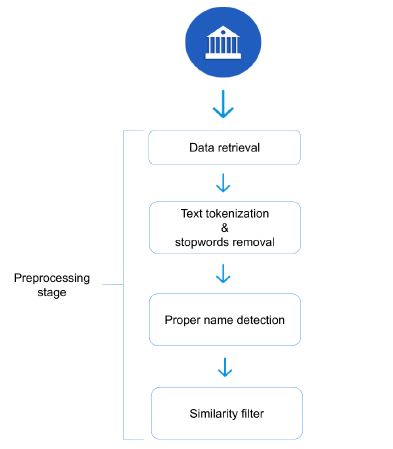



In [ ]:
# this function extracts all the excel files and concatenates into single pandas dataframe
def extract_data(path):
  all_excel_files = glob2.glob(path+'/**/CA*.xlsx')
  print(all_excel_files)
  appended_data =[]

  for file in all_excel_files:
    data = pd.read_excel(file,skiprows=9)
    appended_data.append(data)
  full_data = pd.concat(appended_data)
  return full_data

In [ ]:
path = '/content/drive/My Drive/transact'
data = extract_data(path)

['/content/drive/My Drive/transact/CA20200731_194418.xlsx', '/content/drive/My Drive/transact/CA20200731_195344.xlsx', '/content/drive/My Drive/transact/CA20200731_195122.xlsx', '/content/drive/My Drive/transact/CA20200402_135033.xlsx', '/content/drive/My Drive/transact/CA20200402_135015.xlsx', '/content/drive/My Drive/transact/CA20200602_105523.xlsx', '/content/drive/My Drive/transact/CA20200208_150446.xlsx', '/content/drive/My Drive/transact/CA20200208_150646.xlsx', '/content/drive/My Drive/transact/CA20200208_150257.xlsx', '/content/drive/My Drive/transact/CA20200404_130055.xlsx', '/content/drive/My Drive/transact/CA20200728_150902.xlsx']


In [ ]:
data.shape

(1255, 4)

In [ ]:
data['Libellé']

0      COMMISSION              \nCARTE 223639401 0192...
1      COMMISSION              \nCARTE 223639301 0192...
2      REMISE CARTE            \nCARTE 223639401 0192...
3      REMISE CARTE            \nCARTE 223639301 0192...
4      COMMISSION              \nCARTE 223639401 0067...
                             ...                        
159    PAIEMENT PAR CARTE      \nLEROY MERLIN ROSNY S...
160    PAIEMENT PAR CARTE      \nRELAIS BOUGIVAL BOI ...
161    PAIEMENT PAR CARTE      \nTRANSMETAL LA COURNE...
162                   REMISE DE CHEQUE        \n2753646 
163    COTISATION              \nLE COMPOSE PRO   N°1...
Name: Libellé, Length: 1255, dtype: object

In [ ]:
## Stop word and Punctuation removal

def stopword_punctuate(full_data):

  french_stopwords = set(stopwords.words('french'))

  sp_pattern = re.compile( """[\.\!\"\s\?\-\,\'\/0-9]+""", re.M)
  punctuation_tokenizer = sp_pattern.split

  filt_out =  lambda text: [token for token in text if token.lower() not in french_stopwords]
  fr_stop =  lambda token: len(token) and token.lower() not in french_stopwords

  Token_stopword= []
  for i in range(len(full_data)):
    #print(full_data['Libellé'][i])
    tokens = wt(full_data['Libellé'][i], language="french")
    Token_stopword.append(tokens)

  Token_punctuation= []
  for i in range(len(full_data)):
    #print(full_data['Libellé'][i])
    tokens = punctuation_tokenizer(full_data['Libellé'][i])
    Token_punctuation.append(tokens)
  
  Tokens_without_stop=[filt_out(tk) for tk in Token_stopword]
  Tokens_without_punctuation=[filt_out(tk) for tk in Token_punctuation]

  return Tokens_without_stop,Tokens_without_punctuation 

In [ ]:
data.reset_index(inplace=True)
data['Libellé']= data['Libellé'].astype('str')
Token_stopword, Token_punctuate= stopword_punctuate(data)

In [ ]:
#removing empty lists
Tokens_final_punctuate=[]
for i in Token_punctuate:
  str_list = list(filter(None, i))
  Tokens_final_punctuate.append(str_list)

The data I have is from a French Business entities. So, I used a French stemmer

In [ ]:
# stemming frenc words
def stemmer(token_list):

  stemmer = SnowballStemmer("french", ignore_stopwords=True)
  Tokens_stem =[]
  for i in token_list:
    Tokens_stem.append(list(map(stemmer.stem,i)))
  
  return Tokens_stem

In [ ]:
Tokens_stemmed=stemmer(Tokens_final_punctuate)

After discussions with the entity, we are provided with a outline of some transactions which we utilized for labelling the categories


In [ ]:
# Extract categories from the BT descriptors

def categorize(tokens):

  labels =[]
  for i in range(len(tokens)):
    ls = tokens[i] 
    if any(elem in ['COMMISSION']  for elem in ls): 
      labels.append('Bank charges')
    elif any(elem in ['REMISE']  for elem in ls):
      labels.append('Sales')
    elif any(elem in ['LECLERC', 'CARREFOUR', 'AUCHAN', 'INTERMARCHE', 'LIDL', 'KAVIYEN']  for elem in ls):
      labels.append('Supermarket')
    elif any(elem in ['AMAZON', 'WISH', 'CDISCOUNT']  for elem in ls):
      labels.append('e-commerce')
    elif any(elem in ['SFR', 'MOBILE', 'EDF'] for elem in ls):
      labels.append('Household charges')
    elif any(elem in ['AXA','ASSURANCES'] for elem in ls):
      labels.append('Assurances')
    elif any(elem in ['GNANA', 'METRO', 'ELFI', 'LEROY'] for elem in ls):
      labels.append('Payables')
    elif any(elem in ['SOFINCAL'] for elem in ls):
      labels.append('Rentals')
    elif any(elem in ['salaire'] for elem in ls):
      labels.append('Payroll')
    elif any(elem in ['COTISATION'] for elem in ls):
      labels.append('subscriptions')
    else:
      labels.append('nan')
    
  return labels


In [ ]:
labels= categorize(Tokens_final_punctuate)

In [ ]:
first_token=[]
for token in Tokens_final_punctuate:
  first_token.append(token[0])

In [ ]:
# simillarity detection
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

Simillarity detection as shown in the below 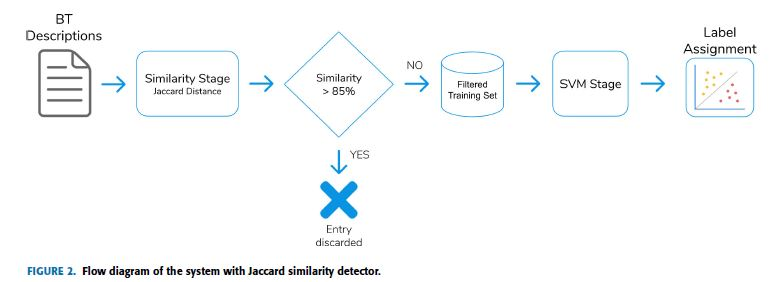fig

In [ ]:
# checking simillarity to reduce training data
def simillarity_detect(Tokens_final,labels):
  index = []
  Tokens_unique = []
  for i in range(len(Tokens_final)):
    if labels[i]== 'Bank charges':
      list1 = Tokens_final[0]
      list2 = Tokens_final[i]
      simillarity_score = jaccard_similarity(list1,list2)
      if simillarity_score<0.85:
        index.append(i)
        Tokens_unique.append(Tokens_final[i])
    elif labels[i]== 'Sales':
      list1 = Tokens_final[2]
      list2 = Tokens_final[i]
      simillarity_score = jaccard_similarity(list1,list2)
      if simillarity_score<0.85:
        index.append(i)
        Tokens_unique.append(Tokens_final[i])
    elif labels[i]== 'Supermarket':
      list1 = Tokens_final[48]
      list2 = Tokens_final[i]
      simillarity_score = jaccard_similarity(list1,list2)
      if simillarity_score<0.85:
        index.append(i)
        Tokens_unique.append(Tokens_final[i])
    elif labels[i]== 'e-commerce':
      list1 = Tokens_final[445]
      list2 = Tokens_final[i]
      simillarity_score = jaccard_similarity(list1,list2)
      if simillarity_score<0.85:
        index.append(i)
        Tokens_unique.append(Tokens_final[i])
    elif labels[i]== 'Household charges':
      list1 = Tokens_final[129]
      list2 = Tokens_final[i]
      simillarity_score = jaccard_similarity(list1,list2)
      if simillarity_score<0.85:
        index.append(i)
        Tokens_unique.append(Tokens_final[i])
    elif labels[i]== 'Assurances':
      list1 = Tokens_final[92]
      list2 = Tokens_final[i]
      simillarity_score = jaccard_similarity(list1,list2)
      if simillarity_score<0.85:
        index.append(i)
        Tokens_unique.append(Tokens_final[i])
    elif labels[i]== 'Payables':
      list1 = Tokens_final[76]
      list2 = Tokens_final[i]
      simillarity_score = jaccard_similarity(list1,list2)
      if simillarity_score<0.85:
        index.append(i)
        Tokens_unique.append(Tokens_final[i])
    elif labels[i]== 'Rentals':
      list1 = Tokens_final[593]
      list2 = Tokens_final[i]
      simillarity_score = jaccard_similarity(list1,list2)
      if simillarity_score<0.85:
        index.append(i)
        Tokens_unique.append(Tokens_final[i])
    elif labels[i]== 'Payroll':
      list1 = Tokens_final[39]
      list2 = Tokens_final[i]
      simillarity_score = jaccard_similarity(list1,list2)
      if simillarity_score<0.85:
        index.append(i)
        Tokens_unique.append(Tokens_final[i])
    
  return index, Tokens_unique
  



In [ ]:
index ,Tokens_unique = simillarity_detect(Tokens_final_punctuate,labels)

In [ ]:
len(Tokens_unique)

0

In [ ]:
## extracting labels and unique stemmed tokens 

Tokens_unique_stem =[]
for i in index:
  token=Tokens_stemmed[i]
  Tokens_unique_stem.append(token)

labels_unique =[]
for i in index:
  labels_unique.append(labels[i])

In [ ]:
import collections

count_list=collections.Counter(labels_unique)

Text(0.5, 0.98, 'Labels Plot')

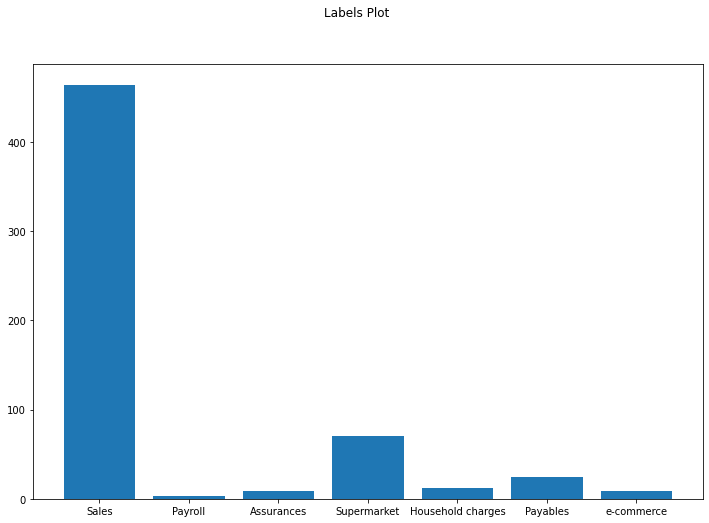

In [ ]:
count_list
names = list(count_list.keys())
values = list(count_list.values())

fig, axs = plt.subplots(figsize=(12, 8))
axs.bar(names, values)
fig.suptitle('Labels Plot')

##**Stage 2:** Linguistic feature extraction and Model building

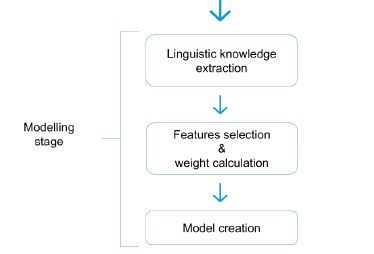

In [ ]:
###lexicon data
## unigrams

def token_unigrams(Tokens_unique_stem,labels_unique):

  token_counter=[]
  counts = dict()


  for i in range(len(Tokens_unique_stem)):
    if labels_unique[i]== 'Bank charges':
      for j in Tokens_unique_stem[i]:
          counts[j] = counts.get(j, 0) + 1

    elif labels_unique[i]== 'Sales':
      for j in Tokens_unique_stem[i]:
          counts[j] = counts.get(j, 0) + 1
    elif labels_unique[i]== 'Supermarket':
      for j in Tokens_unique_stem[i]:
          counts[j] = counts.get(j, 0) + 1
    elif labels_unique[i]== 'e-commerce':
      for j in Tokens_unique_stem[i]:
          counts[j] = counts.get(j, 0) + 1
    elif labels_unique[i]== 'Household charges':
      for j in Tokens_unique_stem[i]:
          counts[j] = counts.get(j, 0) + 1
    elif labels_unique[i]== 'Assurances':
      for j in Tokens_unique_stem[i]:
          counts[j] = counts.get(j, 0) + 1
    elif labels_unique[i]== 'Payables':
      for j in Tokens_unique_stem[i]:
          counts[j] = counts.get(j, 0) + 1
    elif labels_unique[i]== 'Rentals':
      for j in Tokens_unique_stem[i]:
          counts[j] = counts.get(j, 0) + 1
    elif labels_unique[i]== 'Payroll':
      for j in Tokens_unique_stem[i]:
          counts[j] = counts.get(j, 0) + 1

  for key,value in counts.items():
      if value>5:
        token_counter.append(key)
  
  return token_counter



In [ ]:
token_unigram_counter = token_unigrams(Tokens_unique_stem,labels_unique)

Stage 2 follows the below figure

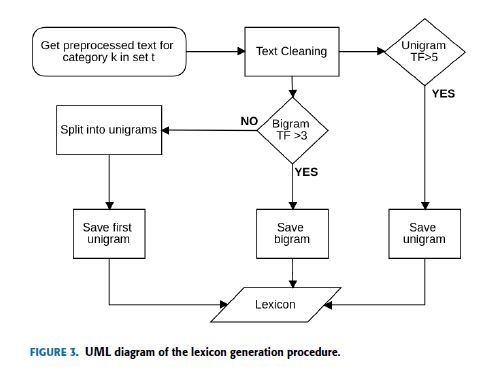

In [ ]:


#bigrams


def token_bigrams(Tokens_unique_stem):

  Token_bigrams=[]

  for tokenlist in Tokens_unique_stem:
      bgrams = list(nltk.bigrams(tokenlist))
      Token_bigrams.append(bgrams)

  bigram_concat=[]
  for i in range(len(Token_bigrams)):
    temp=[]
    for j in range(len(Token_bigrams[i])):      
        temp.append(' '.join(Token_bigrams[i][j]))
    bigram_concat.append(list(temp))

  token_counter_bigrams=[]
  counts_bigrams = dict()
  bigram_unigram=[]

  for i in range(len(bigram_concat)):
    if labels_unique[i]== 'Bank charges':
      for j in bigram_concat[i]:
          counts_bigrams[j] = counts.get(j, 0) + 1
    elif labels_unique[i]== 'Sales':
      for j in bigram_concat[i]:
          counts_bigrams[j] = counts_bigrams.get(j, 0) + 1
    elif labels_unique[i]== 'Supermarket':
      for j in bigram_concat[i]:
          counts_bigrams[j] = counts_bigrams.get(j, 0) + 1
    elif labels_unique[i]== 'e-commerce':
      for j in bigram_concat[i]:
          counts_bigrams[j] = counts_bigrams.get(j, 0) + 1
    elif labels_unique[i]== 'Household charges':
      for j in bigram_concat[i]:
          counts_bigrams[j] = counts_bigrams.get(j, 0) + 1
    elif labels_unique[i]== 'Assurances':
      for j in bigram_concat[i]:
          counts_bigrams[j] = counts_bigrams.get(j, 0) + 1
    elif labels_unique[i]== 'Payables':
      for j in bigram_concat[i]:
          counts_bigrams[j] = counts_bigrams.get(j, 0) + 1
    elif labels_unique[i]== 'Rentals':
      for j in bigram_concat[i]:
          counts_bigrams[j] = counts_bigrams.get(j, 0) + 1
    elif labels_unique[i]== 'Payroll':
      for j in bigram_concat[i]:
          counts_bigrams[j] = counts_bigrams.get(j, 0) + 1

  for key,value in counts_bigrams.items():
      if value>3:
        token_counter_bigrams.append(key)
      else:
        bigram_split=key.split()
        bigram_unigram.append(bigram_split[0])
  
  return bigram_unigram, token_counter_bigrams


In [ ]:
bigram_unigrams, token_bigrams_counter = token_bigrams(Tokens_unique_stem)

**Word Ngrams as Features**

We choose word unigrams and bigrams to train the base model and then add extra features to experiment

In [ ]:
##word unigrams and bigrams"

def word_unigrams_bigrams(Tokens_unique):

  Tokens_unique_lower=[]
  #lower 
  for token_upper in Tokens_unique:
    each_row=[x.lower() for x in token_upper]
    Tokens_unique_lower.append(each_row)

  Token_unique_with_bigrams=[]
  bgrams=[]
  for tokenlist in Tokens_unique_lower:
      bgrams = list(nltk.bigrams(tokenlist))
      temp=[]
      for j in range(len(bgrams)):
          temp.append(' '.join(bgrams[j]))
      
      Token_unique_with_bigrams.append(tokenlist+temp)

  Token_unique_with_bigrams_set=[]
  for tk in Token_unique_with_bigrams:
    Token_unique_with_bigrams_set.append(set(tk))

  return Token_unique_with_bigrams_set


In [ ]:
Token_unigrams_bigrams=word_unigrams_bigrams(Tokens_unique)

**Word2Vec** Model is used to embed the word unigrams and bigrams

In [ ]:
##word2vec vector space model 
def word2vec_model(tokens):

  model = Word2Vec(tokens,min_count=1)

  words=list(model.wv.vocab)

  #print(words)

  model.save('model.bin')
  new_model=Word2Vec.load('model.bin')

  encoded_bt = [[new_model.wv[word] for word in post] for post in tokens]

  return encoded_bt


In [ ]:
encoded_bt= word2vec_model(Token_unigrams_bigrams)

In [ ]:

# preparing encoded word embeddings for SVM
# averaging and padding of word embeddings 
def pad_average(encoded_docs):
  MAX_LENGTH = 20
  padded_posts = []

  for post in encoded_docs:
      # Pad short posts with alternating min/max
      if len(post) < MAX_LENGTH:
          #print(len(post))
          # Method 1
          #pointwise_min = np.minimum.reduce(post)
          #pointwise_max = np.maximum.reduce(post)
          #padding = [pointwise_max, pointwise_min]
          
          # Method 2
          pointwise_avg = np.mean(post,axis=0)
          padding = [pointwise_avg]
          #print(len(padding))

          
          #avg_vec= padding * math.ceil((MAX_LENGTH - len(post) / 2.0))
          avg_vec= padding
          
      # Shorten long posts or those odd number length posts we padded to 51
      elif len(post) > MAX_LENGTH:
          post = post[:MAX_LENGTH]
          pointwise_avg = np.mean(post,axis=0)
          padding = [pointwise_avg]

          avg_vec= padding 
      
      # Add the post to our new list of padded posts
      padded_posts.append(avg_vec)



  return padded_posts

In [ ]:
padded_word_embed=pad_average(encoded_bt)


In [ ]:
bt_variables =[]
for post in padded_word_embed:
  bt_variables.append(np.hstack(post))

In [ ]:
from sklearn.metrics import plot_confusion_matrix


In [ ]:
def model_SVM(var_X,labels):

  #splitting data into training and testing
  X_train, X_test, y_train, y_test = train_test_split(var_X, labels,
                                                      stratify=labels, 
                                                      test_size=0.30)
  # Classifier - Algorithm - SVM
  # fit the training dataset on the classifier
  clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
  clf.fit(X_train,y_train)
  # predict the labels on validation dataset
  predictions_SVM = clf.predict(X_test)
  # Use accuracy_score function to get the accuracy
  print("SVM F1 Score -> ",f1_score(predictions_SVM, y_test, average='macro')*100)

  fig, ax =plt.subplots(figsize=(12,12))
  plot_confusion_matrix(clf, X_test, y_test,ax=ax)
  plt.show() 
  
  return clf

SVM F1 Score ->  24.99359795134443


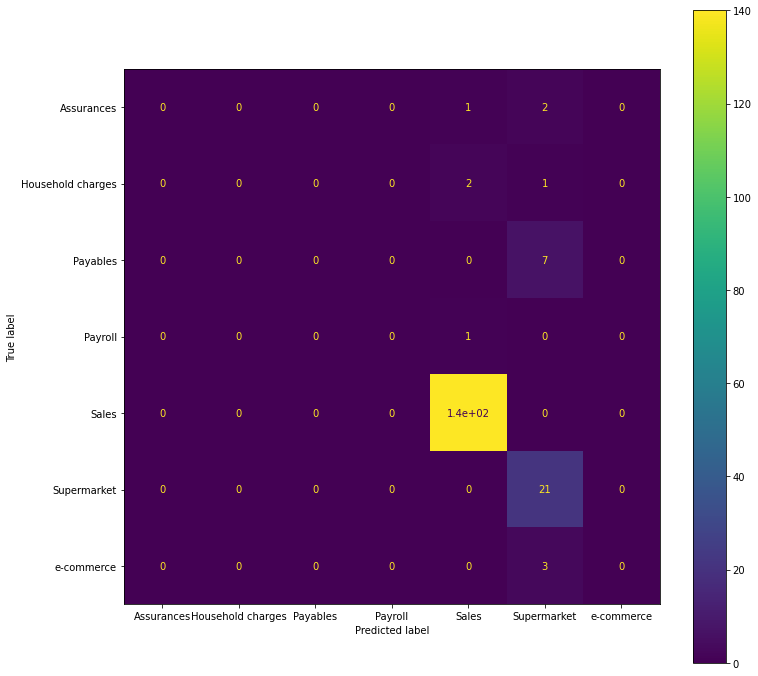

In [ ]:
svm_clf= model_SVM(bt_variables,labels_unique)

####Adding extra variables "sign", "amount" to the dataset and modelling 


In [ ]:

amount=[]
sign =[]

for j in index:
      if  np.isnan(data['Débit euros'][j]):
        amount.append(data['Crédit euros'][j])
        sign.append('pos')
      else:
        amount.append(data['Débit euros'][j])
        sign.append('neg')

In [ ]:
#sign=np.array(sign)
sign=sign.reshape(-1, 1)
enc = OneHotEncoder(handle_unknown='ignore')
sign_onehot=enc.fit_transform(sign).toarray()


In [ ]:
amount=np.array(amount)
amount =  amount[..., np.newaxis]
bt_var_arr=np.array(bt_variables)
btvar_X=np.append(bt_var_arr, amount, axis=1)
btvar_X= np.append(btvar_X,sign_onehot,axis=1)



SVM F1 Score ->  46.94564694564695


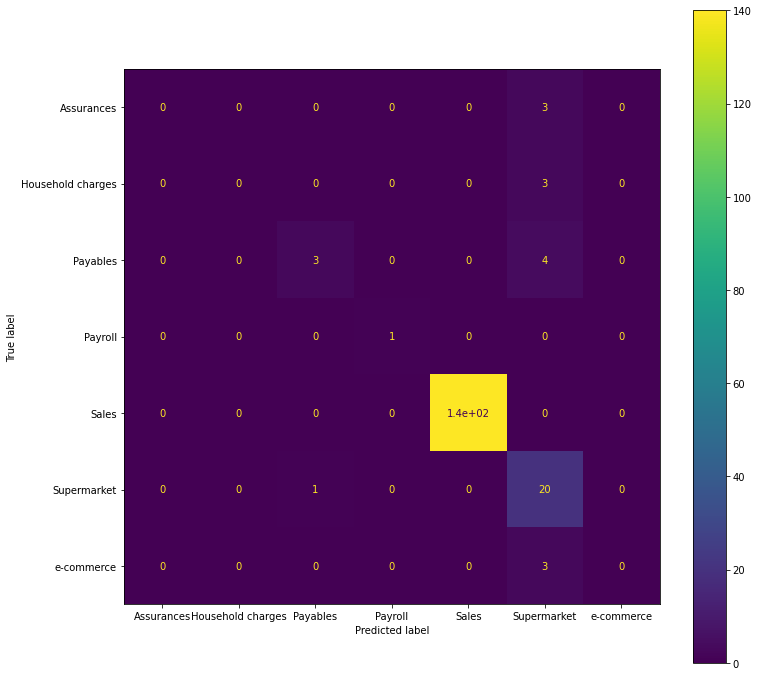

In [ ]:
svm_clf= model_SVM(btvar_X,labels_unique)

**Conclusion**: 

* A lot of transactions in the dataset are 'Sales' which lead to an imbalance 
dataset and reduced the overall accuracy.

* Upsampling less represented categories will improve the model.

* Word embeddings from Word2Vec model can be utlized for simillarity detection of unknown categories .

* Word embeddings combined with LSTM's  is an alterative approach to classify data which can also produce amazing 
results when the data is not available in the training. 

* Already trained models on large texts are avaible for english. https://fauconnier.github.io/ proposed french pretrained word2vec models
which can be utilized for better word embeddings. 

* The dataset utlized in the paper has 30,844 BT descriptions, and we have 591 labelled BT descriptions. The transformations
applied on the lexicons, ngrams etc. are not provided. Even word embeddings to sentence embeddings are not provided. We took average
of word embeddings and padded if necessary which was the best solution specified by some papers[1]. 

* There is a lot of online blogs describing the exact problem. Plaid's blog is a gem in banking and ML. I encourage you to go through this [blog](https://plaid.com/blog/making-sense-of-messy-data/) for a brief understanding. 

**Referrences**: 

[1] Representation learning for very short texts using weighted word embedding aggregation. Cedric De Boom, Steven Van Canneyt, Thomas Demeester, Bart Dhoedt. Pattern Recognition Letters; arxiv:1607.00570. abstract, pdf. See especially Tables 1 and 2.



---

